In [ ]:
# !pip install -r requirements.txt

# import capymoa
# print(capymoa.__version__)

In [ ]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import LeveragingBagging
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.classifier import OnlineSmoothBoost
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation import ClassificationEvaluator, prequential_evaluation, ClassificationWindowedEvaluator
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Processando e Criando Stream para treinamento dos modelos

In [4]:
FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas (não-features)
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
stream, le_global = criar_stream(
    file_path=FILE_RAW,
    target_label_col=TARGET_COL,
    timestamp_col=TIME_COL,
    cols_para_remover=COLS_NAO_FEATURES,
    features_selecionadas=TOP_20_FEATURES
)

--- Iniciando Pipeline: datasets\CICDDoS2019\CICDDoS2019_01_12.csv ---
  [Passo 2/6] Colunas renomeadas.
  [Passo 3/6] Ordenando DataFrame por 'Timestamp'...
  [Passo 4/6] Convertendo valores Infinitos para NaN...
  [Passo 5/6] Removendo colunas, tratando nulos e codificando rótulos...
    - LabelEncoder criado e ajustado. 12 classes encontradas.
    - 7 colunas removidas do conjunto de features.
    - Imputando 2532 valores nulos/infinitos com a MEDIANA...
    - Aplicando seleção de features. Mantendo 20 colunas.
  [Passo 6/6] Criando objeto NumpyStream...
    - Dados finais preparados: X_shape=(88803, 20), y_shape=(88803,).
Stream criado e pronto para uso.


# Algoritmos de Stream Mining

## Leveraging Bagging (LB) 

https://capymoa.org/api/modules/capymoa.classifier.LeveragingBagging.html

* **Schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação prioriza o desempenho, portanto, o desempenho preditivo é modificado. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.

               precision    recall  f1-score   support

       BENIGN     0.9987    0.9994    0.9990     56863
    DrDoS_DNS     0.9635    0.9945    0.9788      5072
   DrDoS_LDAP     0.9500    0.9931    0.9711      2181
  DrDoS_MSSQL     0.9764    0.9710    0.9737      4523
    DrDoS_NTP     0.9809    0.9800    0.9805      1203
DrDoS_NetBIOS     0.9538    0.9573    0.9555      4094
   DrDoS_SNMP     0.9929    0.9471    0.9695      5161
   DrDoS_SSDP     0.7772    0.9847    0.8687      2611
    DrDoS_UDP     0.9816    0.7640    0.8592      3136
          Syn     0.9924    0.9033    0.9458      1583
         TFTP     0.9995    0.9925    0.9960      2009
       UDPLag     0.6773    0.8692    0.7613       367

     accuracy                         0.9811     88803
    macro avg     0.9370    0.9464    0.9383     88803
 weighted avg     0.9832    0.9811    0.9812     88803



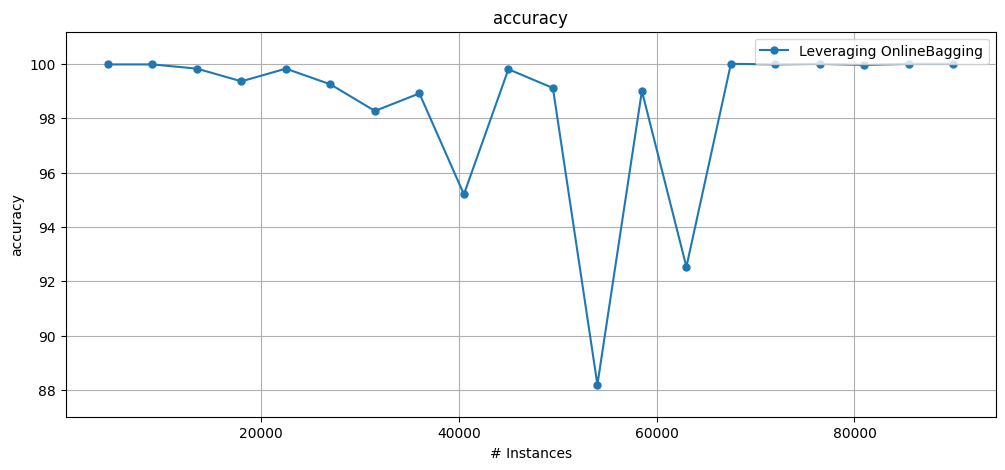

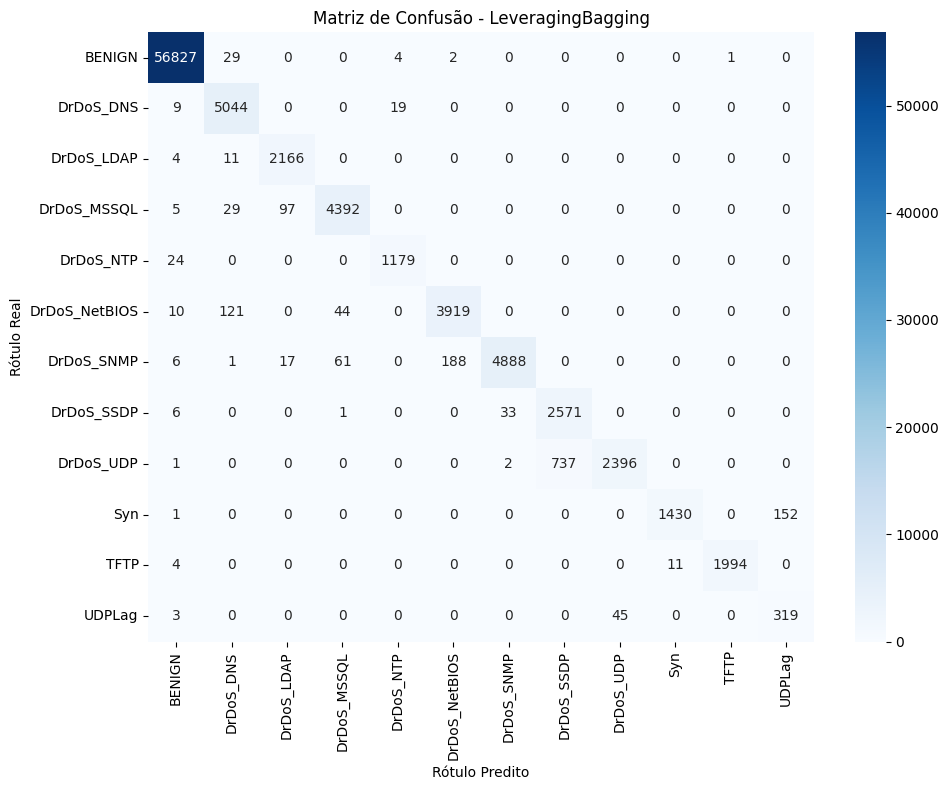

In [5]:
if stream is not None:    
    LB = LeveragingBagging(
        schema=stream.schema, 
        CLI=None, # Padrão (None)
        random_seed=1, # Padrão (1)
        base_learner=None, # Padrão (None)
        ensemble_size=100, # Padrão (100)
        minibatch_size=None, # Padrão (None)
        number_of_jobs=None # Padrão (None)
    )

    classificationEvaluatorLB = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)
    windowedEvaluatorLB = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
    
    y_true_list = []
    y_pred_list = []

    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        prediction = LB.predict(instance)
        windowedEvaluatorLB.update(instance.y_index, prediction)
        classificationEvaluatorLB.update(instance.y_index, prediction)
        LB.train(instance)

        y_true_list.append(instance.y_index)
        y_pred_list.append(prediction)

    results = prequential_evaluation(
        stream=stream, 
        learner=LB, 
        max_instances=None,
        window_size=4500,
        store_predictions=False,
        store_y=False,
        optimise=False,
        restart_stream=True,
        progress_bar=False,
        batch_size=1
    )
    plot_windowed_results(results, metric="accuracy")

    gerar_relatorio_e_heatmap(
        y_true_list, 
        y_pred_list, 
        le_global, 
        model_name="LeveragingBagging"
    )

else:
    print("ERRO: O Stream não existe.")


## Hoeffding Adaptive Tree (HAT)

https://capymoa.org/api/modules/capymoa.classifier.HoeffdingAdaptiveTree.html

* **schema** - o esquema do fluxo.
* **random_seed** – a semente aleatória passada para o algoritmo de aprendizado do Moa.
* **grace_period** – o número de instâncias que uma folha deve observar entre as tentativas de divisão.
* **split_criterion** – o critério de divisão a ser usado. O padrão é InfoGainSplitCriterion .
* **confidence**  – o nível de confiança para calcular o Limite de Hoeffding (1 - delta). O valor padrão é 1e-3 . Valores mais próximos de zero implicam em maiores atrasos na decisão dividida.
* **tie_threshold** – o limite abaixo do qual uma divisão será forçada para desempatar.
* **leaf_prediction** – o mecanismo de predição usado nas folhas.
    * 0 - Classe majoritária
    * 1 - Naive Bayes
    * 2 - Naive Bayes adaptativo

* **nb_threshold** – o número de instâncias que uma folha deve observar antes de permitir o Naive Bayes.
* **numeric_attribute_observer** – o Splitter ou Observador de Atributos (AO) usado para monitorar as estatísticas de classe de recursos numéricos e realizar divisões.
* **binary_split** – Se verdadeiro, permite apenas divisões binárias.
* **max_byte_size** – o tamanho máximo da árvore, em bytes.
* **memory_estimate_period** – Intervalo (número de instâncias processadas) entre as verificações de consumo de memória.
* **stop_mem_management** – ​​Se verdadeiro, interrompe o crescimento assim que o limite de memória for atingido.
* **remove_poor_attrs** – Se verdadeiro, desativa atributos de baixa qualidade para reduzir o uso de memória.
* **disable_prepruning** – Se verdadeiro, desativa a pré-poda de árvores baseada em mérito.

               precision    recall  f1-score   support

       BENIGN     0.9984    0.9987    0.9986     56863
    DrDoS_DNS     0.9850    0.9945    0.9897      5072
   DrDoS_LDAP     0.9738    0.9702    0.9720      2181
  DrDoS_MSSQL     0.9960    0.9881    0.9920      4523
    DrDoS_NTP     0.9867    0.9875    0.9871      1203
DrDoS_NetBIOS     0.9954    0.9946    0.9950      4094
   DrDoS_SNMP     0.9977    0.9955    0.9966      5161
   DrDoS_SSDP     0.9687    0.9950    0.9817      2611
    DrDoS_UDP     0.9839    0.9735    0.9787      3136
          Syn     0.9889    0.8414    0.9092      1583
         TFTP     0.9965    0.9925    0.9945      2009
       UDPLag     0.5611    0.8638    0.6803       367

     accuracy                         0.9922     88803
    macro avg     0.9527    0.9663    0.9563     88803
 weighted avg     0.9932    0.9922    0.9924     88803



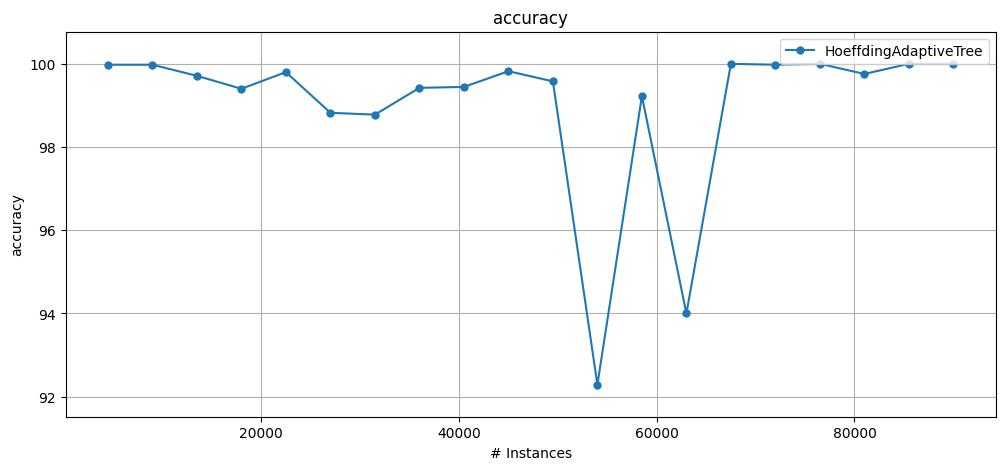

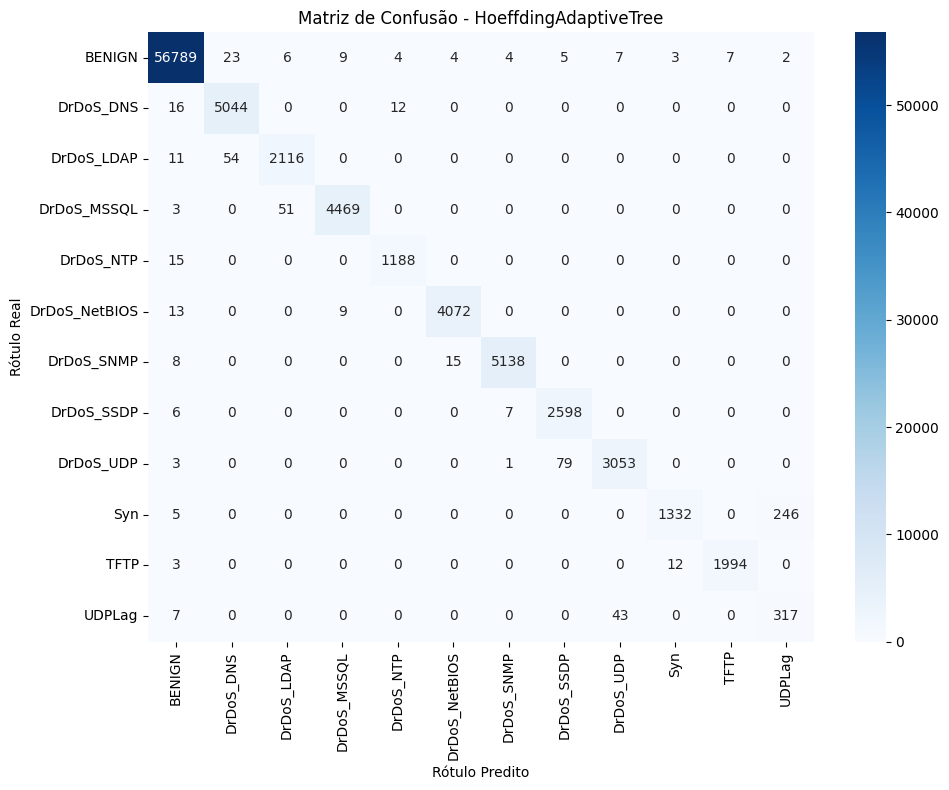

In [7]:
if stream is not None:    
    HAT = HoeffdingAdaptiveTree(
        schema=stream.schema,
        random_seed=0, # Padrão (0)
        grace_period=200, # Padrão (200)
        split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
        confidence=0.01, # Padrão (0.01)
        tie_threshold=0.05, # Padrão (0.05)
        leaf_prediction='NaiveBayesAdaptive',
        nb_threshold=0, # Padrão (0)
        numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
        binary_split=False, # Padrão (False)
        max_byte_size=33554432, # Padrão (32MB)
        memory_estimate_period=1000000, # Padrão (1.000.000)
        stop_mem_management=True, # Padrão (True)
        remove_poor_attrs=False, # Padrão (False)
        disable_prepruning=True # Padrão (True)
    )

    classificationEvaluatorHAT = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)
    windowedEvaluatorHAT = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
    
    y_true_list = []
    y_pred_list = []

    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        prediction = HAT.predict(instance)
        windowedEvaluatorHAT.update(instance.y_index, prediction)
        classificationEvaluatorHAT.update(instance.y_index, prediction)
        HAT.train(instance)

        y_true_list.append(instance.y_index)
        y_pred_list.append(prediction)

    results = prequential_evaluation(
        stream=stream, 
        learner=HAT, 
        window_size=4500
    )
    plot_windowed_results(results, metric="accuracy")

    gerar_relatorio_e_heatmap(
        y_true_list, 
        y_pred_list, 
        le_global, 
        model_name="HoeffdingAdaptiveTree"
    )

else:
    print("ERRO: O Stream não existe.")

## Online Smooth Boost (OSM)

https://capymoa.org/api/modules/capymoa.classifier.OnlineSmoothBoost.html

* **schema** – O esquema do fluxo.
* **random_seed** – A semente aleatória passada para o algoritmo de aprendizado MOA.
* **base_learner** – O modelo base a ser treinado. O padrão é trees.HoeffdingTree.
* **boosting_iterations** – O número de iterações de boosting (tamanho do ensemble).
* **gamma** – O valor do parâmetro gama.

               precision    recall  f1-score   support

       BENIGN     0.9975    0.9797    0.9885     56863
    DrDoS_DNS     0.8372    0.9986    0.9108      5072
   DrDoS_LDAP     0.9065    0.9917    0.9472      2181
  DrDoS_MSSQL     0.9236    0.9509    0.9370      4523
    DrDoS_NTP     0.9529    0.9751    0.9638      1203
DrDoS_NetBIOS     0.9981    0.9123    0.9533      4094
   DrDoS_SNMP     0.9959    0.9986    0.9973      5161
   DrDoS_SSDP     0.8987    0.9958    0.9448      2611
    DrDoS_UDP     0.9958    0.9136    0.9529      3136
          Syn     0.9912    0.8490    0.9146      1583
         TFTP     0.9586    0.9920    0.9750      2009
       UDPLag     0.5292    0.7411    0.6175       367

     accuracy                         0.9726     88803
    macro avg     0.9154    0.9415    0.9252     88803
 weighted avg     0.9758    0.9726    0.9733     88803



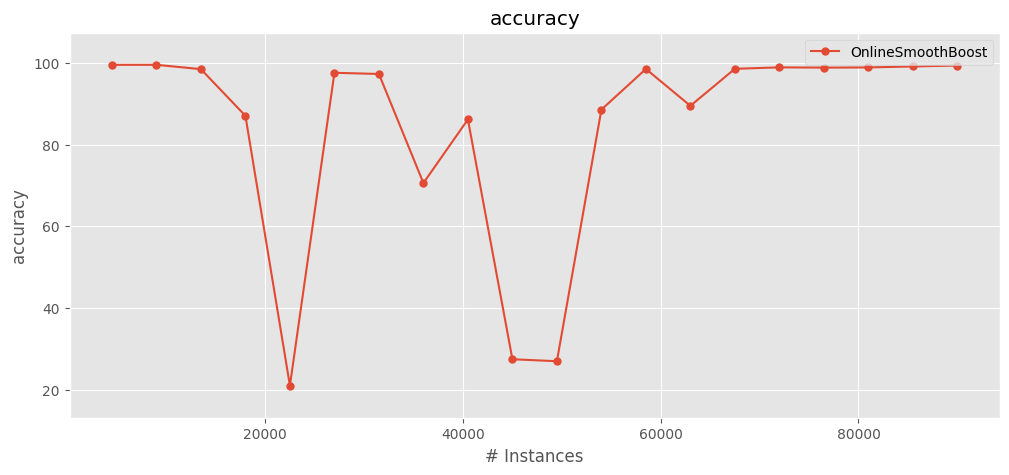

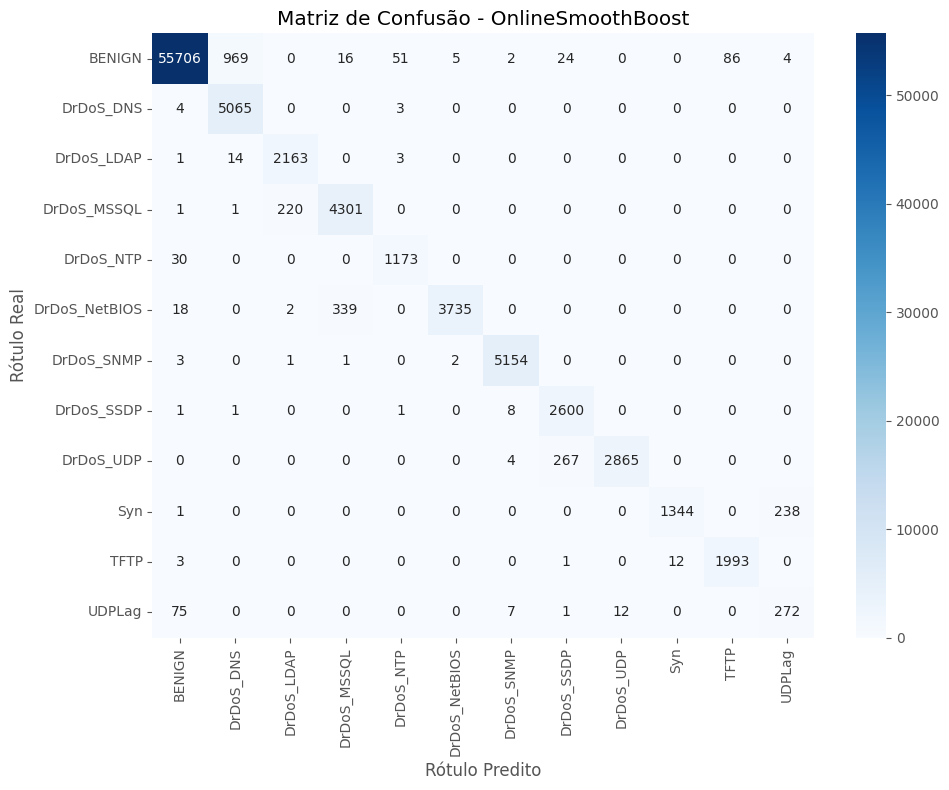

In [82]:
if stream is not None:    
    OSB = OnlineSmoothBoost(
        schema=stream.schema, 
        random_seed=0, # Padrão (0)
        base_learner='trees.HoeffdingTree', # Padrão (trees.HoeffdingTree)
        boosting_iterations=100, # Padrão (100)
        gamma=0.1 # Padrão (0.1)
    )

    classificationEvaluatorOSB = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)
    windowedEvaluatorOSB = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
    
    y_true_list = []
    y_pred_list = []

    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        prediction = OSB.predict(instance)
        windowedEvaluatorOSB.update(instance.y_index, prediction)
        classificationEvaluatorOSB.update(instance.y_index, prediction)
        OSB.train(instance)

        y_true_list.append(instance.y_index)
        y_pred_list.append(prediction)

    results = prequential_evaluation(
        stream=stream, 
        learner=OSB, 
        window_size=4500
    )
    plot_windowed_results(results, metric="accuracy")

    gerar_relatorio_e_heatmap(
        y_true_list, 
        y_pred_list, 
        le_global, 
        model_name="OnlineSmoothBoost"
    )

else:
    print("ERRO: O Stream não existe.")


## Adaptive Random Forest (ARF)

https://capymoa.org/api/modules/capymoa.classifier.AdaptiveRandomForestClassifier.html#capymoa.classifier.AdaptiveRandomForestClassifier

* **schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **max_features** – O número máximo de características a serem consideradas ao dividir um nó. Se fornecido como um número de ponto flutuante entre 0,0 e 1,0, representa a porcentagem de características a serem consideradas. Se fornecido como um número inteiro, especifica o número exato de características a serem consideradas. Se fornecido como a string “sqrt”, indica a raiz quadrada do número total de características. Se não for fornecido, o valor padrão é 60%.
* **lambda_param** – O parâmetro lambda que controla a distribuição de Poisson para a simulação de bagging online.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação foi projetada para ser extremamente paralela, o que significa que os cálculos do algoritmo podem ser distribuídos eficientemente entre várias unidades de processamento sem sacrificar o desempenho preditivo. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.
* **drift_detection_method** – O método usado para detecção de deriva.
* **warning_detection_method** – O método usado para detecção de avisos.
* **disable_weighted_vote** – Indica se a votação ponderada deve ser desativada.
* **disable_drift_detection** – Indica se a detecção de deriva deve ser desativada.
* **disable_background_learner** – Indica se o aprendizado em segundo plano deve ser desativado.

               precision    recall  f1-score   support

       BENIGN     0.9990    0.9990    0.9990     56863
    DrDoS_DNS     0.9953    0.9955    0.9954      5072
   DrDoS_LDAP     0.9945    0.9950    0.9947      2181
  DrDoS_MSSQL     0.9978    0.9973    0.9976      4523
    DrDoS_NTP     0.9917    0.9900    0.9908      1203
DrDoS_NetBIOS     0.9966    0.9958    0.9962      4094
   DrDoS_SNMP     0.9963    0.9965    0.9964      5161
   DrDoS_SSDP     0.9908    0.9946    0.9927      2611
    DrDoS_UDP     0.9914    0.9920    0.9917      3136
          Syn     0.9880    0.9867    0.9874      1583
         TFTP     0.9975    0.9925    0.9950      2009
       UDPLag     0.9355    0.9482    0.9418       367

     accuracy                         0.9972     88803
    macro avg     0.9895    0.9903    0.9899     88803
 weighted avg     0.9972    0.9972    0.9972     88803



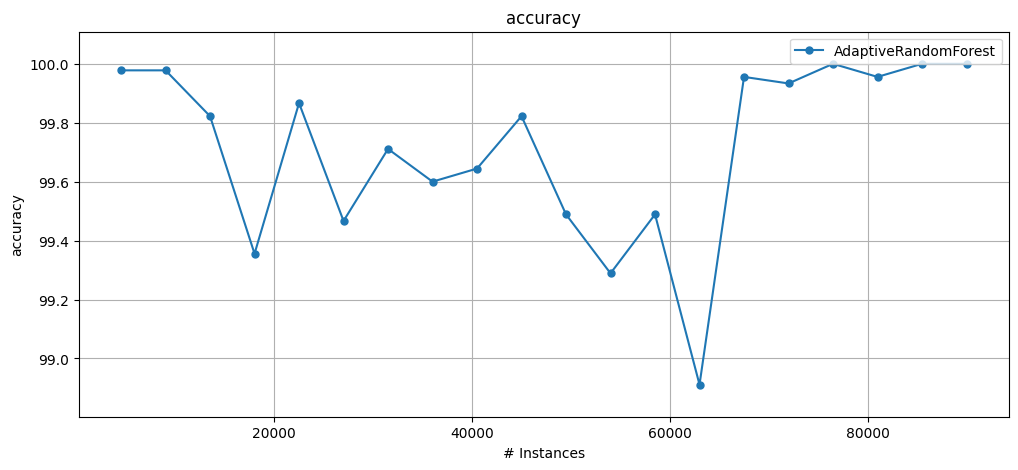

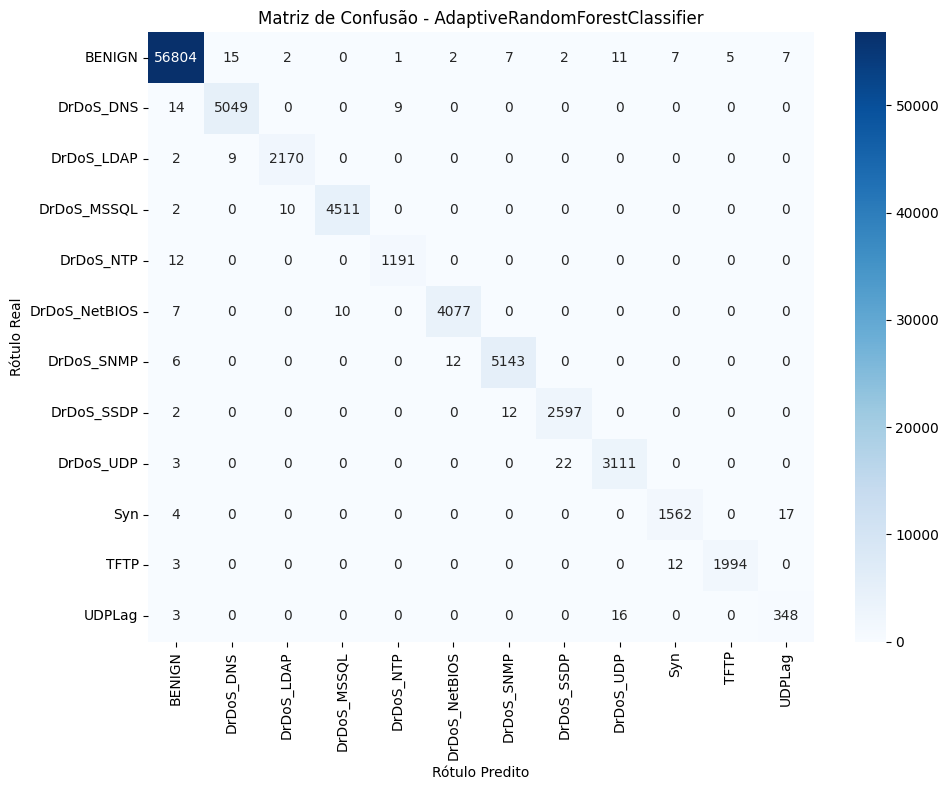

In [8]:
if stream is not None:    
    ARF = AdaptiveRandomForestClassifier(
        schema=stream.schema,
        CLI=None, # Padrão (None)
        random_seed=1, # Padrão (1)
        base_learner=None, # Padrão (None)
        ensemble_size=100, # Padrão (100)
        max_features=0.6, # Padrão (0.6)
        lambda_param=6.0, # Padrão (6.0)
        minibatch_size=None, # Padrão (None)
        number_of_jobs=1, # Padrão (1)
        drift_detection_method=None, # Padrão (None)
        warning_detection_method=None, # Padrão (None)
        disable_weighted_vote=False, # Padrão (False)
        disable_drift_detection=False, # Padrão (False)
        disable_background_learner=False # Padrão (False)        
    )

    classificationEvaluatorARF = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)
    windowedEvaluatorARF = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
    
    y_true_list = []
    y_pred_list = []

    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        prediction = ARF.predict(instance)
        windowedEvaluatorARF.update(instance.y_index, prediction)
        classificationEvaluatorARF.update(instance.y_index, prediction)
        ARF.train(instance)

        y_true_list.append(instance.y_index)
        y_pred_list.append(prediction)

    results = prequential_evaluation(
        stream=stream, 
        learner=ARF, 
        window_size=4500
    )
    plot_windowed_results(results, metric="accuracy")
    
    gerar_relatorio_e_heatmap(
        y_true_list, 
        y_pred_list, 
        le_global, 
        model_name="AdaptiveRandomForestClassifier"
    )

else:
    print("ERRO: O Stream não existe.")


# Avaliando um único fluxo usando múltiplos Algoritmos

In [9]:
OSB = OnlineSmoothBoost(
    schema=stream.schema, 
    random_seed=0, # Padrão (0)
    base_learner='trees.HoeffdingTree', # Padrão (trees.HoeffdingTree)
    boosting_iterations=100, # Padrão (100)
    gamma=0.1 # Padrão (0.1)
)

HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0, # Padrão (0)
    grace_period=200, # Padrão (200)
    split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
    confidence=0.01, # Padrão (0.01)
    tie_threshold=0.05, # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0, # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False, # Padrão (False)
    max_byte_size=33554432, # Padrão (32MB)
    memory_estimate_period=1000000, # Padrão (1.000.000)
    stop_mem_management=True, # Padrão (True)
    remove_poor_attrs=False, # Padrão (False)
    disable_prepruning=True # Padrão (True)
)

LB = LeveragingBagging(
    schema=stream.schema, 
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=None # Padrão (None)
)

ARF = AdaptiveRandomForestClassifier(
    schema=stream.schema,
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    max_features=0.6, # Padrão (0.6)
    lambda_param=6.0, # Padrão (6.0)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=1, # Padrão (1)
    drift_detection_method=None, # Padrão (None)
    warning_detection_method=None, # Padrão (None)
    disable_weighted_vote=False, # Padrão (False)
    disable_drift_detection=False, # Padrão (False)
    disable_background_learner=False # Padrão (False)        
)

LB accuracy = 98.11042419738072 
HAT accuracy = 99.21962095875139 
OSB accuracy = 97.26135378309291 
ARF accuracy = 99.72298233167798


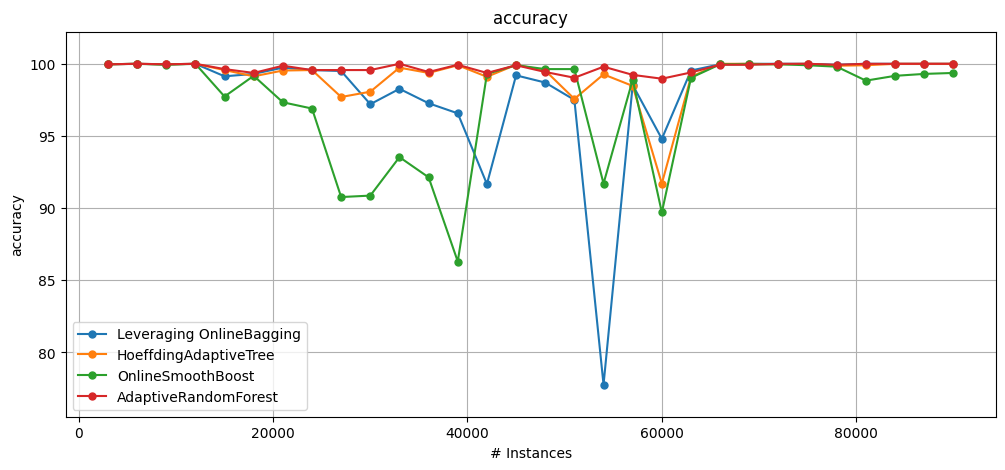

In [10]:
learners = {
    "LB": LB,
    "HAT": HAT,
    "OSB": OSB,
    "ARF": ARF
}

stream.restart()
results = prequential_evaluation_multiple_learners(stream, learners, window_size=3000)

print(f"LB accuracy = {results['LB'].cumulative.accuracy()} \nHAT accuracy = {results['HAT'].cumulative.accuracy()} \nOSB accuracy = {results['OSB'].cumulative.accuracy()} \nARF accuracy = {results['ARF'].cumulative.accuracy()}")
plot_windowed_results(results["LB"], results["HAT"], results["OSB"], results["ARF"], metric="accuracy")